In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
keep_cols = [
    "engine_displacement",
    "horsepower",
    "vehicle_weight",
    "model_year",
    "fuel_efficiency_mpg",
]

df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv',usecols=keep_cols)
df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


In [3]:
print(df.shape)

(9704, 5)


Skew (Pearson): engine_displacement   -0.002872
horsepower             0.001213
vehicle_weight         0.010606
model_year             0.007572
fuel_efficiency_mpg   -0.012062
dtype: float64
P95 / median: engine_displacement    1.400000
horsepower             1.342282
vehicle_weight         1.276135
model_year             1.004970
fuel_efficiency_mpg    1.276155
dtype: float64
P99 / median: engine_displacement    1.550000
horsepower             1.463087
vehicle_weight         1.395804
model_year             1.005467
fuel_efficiency_mpg    1.391578
dtype: float64
Max: engine_displacement     380.000000
horsepower              271.000000
vehicle_weight         4739.077089
model_year             2023.000000
fuel_efficiency_mpg      25.967222
dtype: float64


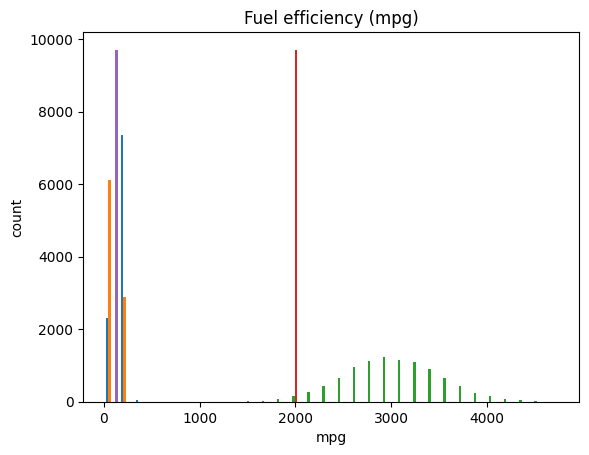

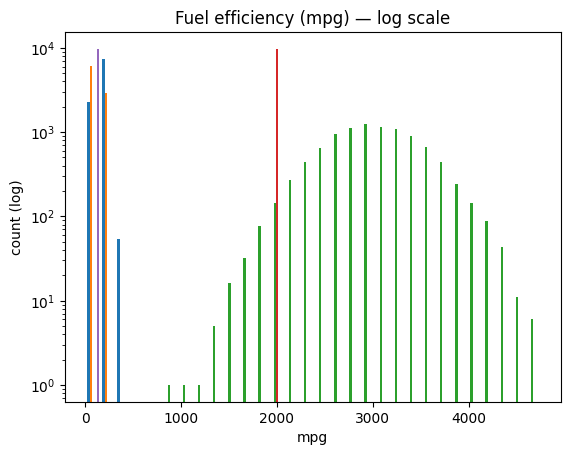

In [4]:
print("Skew (Pearson):", df.skew())  # >0 => right tail
p50 = df.median()
p95 = df.quantile(0.95)
p99 = df.quantile(0.99)
print("P95 / median:", p95 / p50)
print("P99 / median:", p99 / p50)
print("Max:", df.max())

# Histogram (linear y-axis)
plt.figure()
plt.hist(df, bins=30)
plt.title("Fuel efficiency (mpg)")
plt.xlabel("mpg")
plt.ylabel("count")
plt.show()

# Histogram with log y-axis (helps reveal tail)
plt.figure()
plt.hist(df, bins=30, log=True)
plt.title("Fuel efficiency (mpg) — log scale")
plt.xlabel("mpg")
plt.ylabel("count (log)")
plt.show()

##### It’s right-skewed (long tail on the high-mpg side). A few very efficient cars pull the distribution’s upper end.

## Question 1

There's one column with missing values. What is it?

1. 'engine_displacement'
2. 'horsepower'
3. 'vehicle_weight'
4. 'model_year'


In [5]:
missing_col = [c for c in keep_cols if df[c].isna().any()][0]
print("Missing column:", missing_col)

Missing column: horsepower


## Question 2

What's the median (50% percentile) for variable 'horsepower'?

1. 49
2. 99
3. 149
4. 199


In [6]:
print("Median horsepower:", df['horsepower'].median())

Median horsepower: 149.0


### Prepare and split the dataset
- Shuffle the dataset (the filtered one you created above), use seed 42.
- Split your data in train/val/test sets, with 60%/20%/20% distribution.
- Use the same code as in the lectures

In [7]:
n = len(df)
np.random.seed(42)
idx = np.arange(n)
np.random.shuffle(idx)

n_val = int(n * 0.20)
n_test = int(n * 0.20)
n_train = n - n_val - n_test

df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
df_val   = df.iloc[idx[n_train:n_train + n_val]].reset_index(drop=True)
df_test  = df.iloc[idx[n_train + n_val:]].reset_index(drop=True)

In [8]:
df_train.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,220,144.0,2535.887591,2009,16.642943
1,160,141.0,2741.170484,2019,16.298377
2,230,155.0,2471.880237,2017,18.591822
3,150,206.0,3748.164469,2015,11.818843
4,300,111.0,2135.716359,2006,19.402209


### Question 3
- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)

#### Which option gives better RMSE?
Options:

1. With 0
2. With mean
3. Both are equally good

In [9]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]


def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [10]:
features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
target = 'fuel_efficiency_mpg'

def prepare_X(df):
    return df[features].values

# ---- Option A: fill missing horsepower with 0 ----
tr0 = df_train.copy()
va0 = df_val.copy()
tr0['horsepower'] = tr0['horsepower'].fillna(0)
va0['horsepower'] = va0['horsepower'].fillna(0)

X_tr0, y_tr0 = prepare_X(tr0), tr0[target].values
X_va0, y_va0 = prepare_X(va0), va0[target].values

w0_0, w_0 = train_linear_regression(X_tr0, y_tr0)
y_pred0 = w0_0 + X_va0.dot(w_0)
rmse0 = round(rmse(y_va0, y_pred0), 2)

# ---- Option B: fill missing horsepower with TRAIN MEAN ----
mean_hp = df_train['horsepower'].mean()
trm = df_train.copy()
vam = df_val.copy()
trm['horsepower'] = trm['horsepower'].fillna(mean_hp)
vam['horsepower'] = vam['horsepower'].fillna(mean_hp)

X_trm, y_trm = prepare_X(trm), trm[target].values
X_vam, y_vam = prepare_X(vam), vam[target].values

w0_m, w_m = train_linear_regression(X_trm, y_trm)
y_predm = w0_m + X_vam.dot(w_m)
rmsem = round(rmse(y_vam, y_predm), 2)

print("RMSE (fill 0):", rmse0)
print("RMSE (fill mean):", rmsem)
print("Better:", "mean" if rmsem < rmse0 else ("0" if rmse0 < rmsem else "equal"))


RMSE (fill 0): 0.52
RMSE (fill mean): 0.46
Better: mean


### Question 4

- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?
- If multiple options give the same best RMSE, select the smallest r.

Options:

1. 0
2. 0.01
3. 1
4. 10
5. 100

In [11]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [12]:
features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
target = 'fuel_efficiency_mpg'

def prepare_X(df):
    X = df[features].copy()
    X['horsepower'] = X['horsepower'].fillna(0)  # fill NAs with 0
    return X.values

X_tr = prepare_X(df_train)
y_tr = df_train[target].values
X_va = prepare_X(df_val)
y_va = df_val[target].values

rs = [0, 0.01, 0.1, 1, 5, 10, 100]
scores = {}

for r in rs:
    w0, w = train_linear_regression_reg(X_tr, y_tr, r=r)
    y_pred = w0 + X_va.dot(w)
    score = round(rmse(y_va, y_pred), 2)
    scores[r] = score
    print(r, score)

best_r = min(scores, key=lambda k: (scores[k], k))  # tie -> smallest r
print('best r:', best_r, 'RMSE:', scores[best_r])


0 0.52
0.01 0.52
0.1 0.52
1 0.52
5 0.52
10 0.52
100 0.52
best r: 0 RMSE: 0.52


### Question 5
- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
- Round the result to 3 decimal digits (round(std, 3))

What's the value of std?

1. 0.001
2. 0.006
3. 0.060
4. 0.600

Note: Standard deviation shows how different the values are. If it's low, then all values are approximately the same. If it's high, the values are different. If standard deviation of scores is low, then our model is stable.

In [13]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

def prepare_X(d):
    X = d[features].copy()
    X['horsepower'] = X['horsepower'].fillna(0)  # fill NAs with 0
    return X.values

def split(d, seed):
    n = len(d)
    idx = np.arange(n)
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)
    n_val = n_test = int(n * 0.2)
    n_train = n - n_val - n_test
    return (
        d.iloc[idx[:n_train]].reset_index(drop=True),
        d.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True),
        d.iloc[idx[n_train+n_val:]].reset_index(drop=True),
    )

rmses = []
for seed in range(10):  # seeds 0..9
    df_train, df_val, _ = split(df, seed)
    X_tr, y_tr = prepare_X(df_train), df_train[target].values
    X_va, y_va = prepare_X(df_val), df_val[target].values
    w0, w = train_linear_regression(X_tr, y_tr)
    rmses.append(rmse(y_va, w0 + X_va @ w))

std = np.std(rmses)
print([round(s, 3) for s in rmses])
print("std:", round(std, 3))


[np.float64(0.521), np.float64(0.524), np.float64(0.525), np.float64(0.524), np.float64(0.526), np.float64(0.526), np.float64(0.52), np.float64(0.511), np.float64(0.52), np.float64(0.532)]
std: 0.005


### Question 6
- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.
- What's the RMSE on the test dataset?

Options:

1. 0.15
2. 0.515
3. 5.15
4. 51.5

In [14]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X) + r * np.eye(X.shape[1])
    w_full = np.linalg.inv(XTX).dot(X.T).dot(y)
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    return np.sqrt(((y - y_pred) ** 2).mean())

def prepare_X(d):
    X = d[features].copy()
    X['horsepower'] = X['horsepower'].fillna(0)
    return X.values

# split with seed=9 (60/20/20)
n = len(df)
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
df_val   = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
df_test  = df.iloc[idx[n_train+n_val:]].reset_index(drop=True)

# combine train + val
df_tr_full = pd.concat([df_train, df_val], ignore_index=True)

# train r=0.001, fill NAs with 0
X_tr, y_tr = prepare_X(df_tr_full), df_tr_full[target].values
X_te, y_te = prepare_X(df_test), df_test[target].values

w0, w = train_linear_regression_reg(X_tr, y_tr, r=0.001)
y_pred = w0 + X_te.dot(w)

print("Test RMSE:", round(rmse(y_te, y_pred), 3)) 

Test RMSE: 0.516
